In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from astropy.io import fits
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
sys.path.append('../visualization')
import acd
from tqdm import tqdm
import viz_2d as viz
import bandpass_filter
import util
import pickle as pkl
plt.style.use('dark_background')

from data import *
data_path = '/scratch/users/vision/data/cosmo'
torch.manual_seed(42)
np.random.seed(42)
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  oj(data_path, 'z1_256'))

In [ ]:
# plt.figure(figsize=(15,5))
plt.figure(figsize=(8, 8))
R, C = 2, 2
for i in range(len(mnu_dataset)):
    sample = mnu_dataset[i]

    #print(i, sample['image'].shape, sample['params'].shape)

    plt.subplot(R, C, i + 1)
    plt.axis('off')
    plt.imshow(np.squeeze(sample['image']), cmap='magma',vmax=0.15,vmin=-0.05 )
#     plt.title(r"$m_\nu$=%0.2f; $\Omega_m$=%0.2f; $10^9A_s$=%0.2f"%(sample['params'][0], sample['params'][1], sample['params'][2] ) )

    if i == 3:
        break
plt.tight_layout()
plt.show()

## Load the model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
import time
import os
import copy



# Modifying the model to predict the three cosmological parameters from single channel images
model_ft = models.resnet18(pretrained=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load(oj(data_path, 'resnet18_state_dict')))
model_ft.eval()


# vgg
# model_ft = models.vgg16(pretrained=False)
# model_ft.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# num_ftrs = 4096 # model_ft.fc.n_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, 3)
# model_ft = model_ft.to(device)
# model_ft.load_state_dict(torch.load(oj(data_path, 'vgg16_adam_9_0.012')))
# model_ft.eval()

cuda:0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
data_transform = transforms.Compose([
        ToTensor()
])
dataloader = torch.utils.data.DataLoader(MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=data_transform), batch_size=64, 
                                         shuffle=True, num_workers=4)

# check that it makes reasonable preds

In [ ]:
device = 'cuda'
model_ft = model_ft.to(device)
with torch.no_grad():
    for data in dataloader:
        inputs, params = data['image'], data['params']
        inputs = inputs.to(device)
        params = params.to(device)
        outputs = model_ft(inputs)
        break
        
plt.scatter(params.cpu()[:,1], outputs.cpu()[:,1])
plt.xlabel('true param')
plt.ylabel('predicted param')

# analyze one prediction

In [6]:
# example im
sample = mnu_dataset[1]
im = np.squeeze(sample['image']).astype(np.float32)
# im_t = torch.Tensor(im).reshape(1, 1, 256, 256)

# example transform
t = util.Transforms()
t.sigma = 0.5 # [0, 1]
transform = t.bandpass_filter

In [ ]:
t.sigma = 0.2
util.visualize(im, transform)

# plt.figure(dpi=200)
# plt.axis('off')
# plt.imshow(im, cmap='magma', vmax=0.15, vmin=-0.05)
# plt.show()

In [ ]:
R, C = 2, 5
plt.figure(dpi=300, figsize=(10, 5))
for i in range(10):
    t.sigma = i * 0.1
    plt.subplot(R, C, i + 1)
    if i == 0:
        plt.imshow(im, cmap='magma') #, vmax=0.15, vmin=-0.05)
        plt.title('original image')
    else:
        plt.title(f'{t.sigma:0.1f}')
        plt.imshow(transform(im), cmap='magma') #, vmax=0.15, vmin=-0.05)
    plt.axis('off')
plt.tight_layout()

**calc cd scores**

In [ ]:
def calc_scores(im_t, model_ft, transform, 
           device='cuda', sigmas=np.linspace(0.1, 0.90, 100)):
    with torch.no_grad():
        x = deepcopy(im_t).to(device)
        model_ft = model_ft.to(device)
        
        scores = []
        for sigma in sigmas:
            t.sigma = sigma
            score = acd.cd(x, model_ft, mask=None, model_type='resnet18', 
                  device=device, transform=transform)[0].flatten().detach() #[class_num].item()
            scores.append(score)

    return scores

sigmas = np.linspace(0.1, 0.90, 100)
transform = t.bandpass_filter
np.random.seed(42)
sample_nums = np.random.randint(0, 100000, size=5000)
scores_list = []
for i, sample_num in tqdm(enumerate(sample_nums)):
    sample = mnu_dataset[sample_num]
    im = np.squeeze(sample['image']).astype(np.float32)
    im_t = torch.Tensor(im).reshape(1, 1, 256, 256)    
    class_num = 1 # output is: [M_nu(eV), Omega_m 10^9*A_s, sigma_8(derived)]
    scores_list.append(calc_scores(im_t, model_ft, transform, sigmas=sigmas)) #, class_num=1))
    if i % 100 == 50:
        pkl.dump({'sample_nums': sample_nums, 'scores_list': scores_list}, 
                 open(f'scores_list_{i}.pkl', 'wb'))

180it [51:53, 17.16s/it]

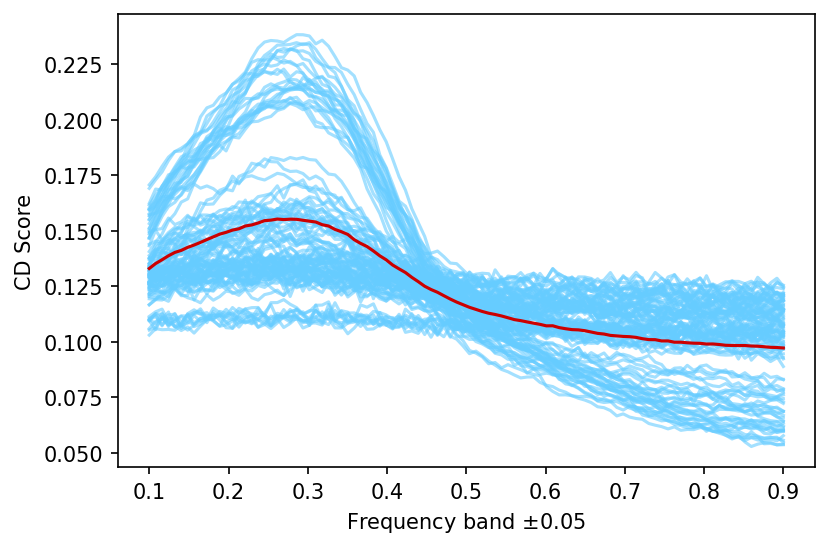

In [110]:
# plot
scores_list = pkl.load(open('scores_list_100.pkl', 'rb'))
plt.figure(dpi=150)
plt.plot(sigmas, np.array(scores_list).T, '-', alpha=0.6, color=cb)
plt.plot(sigmas, np.array(scores_list).T.mean(axis=1), '-', color=cr)
plt.xlabel('Frequency band $\pm 0.05$')
# plt.xscale('log')
plt.ylabel('CD Score')
plt.show()    

In [50]:
with torch.no_grad():
    x = deepcopy(im_t)
    score = cd.cd(x, model_ft, mask=None, model_type='resnet18', 
          device='cuda', transform=transform)[0].flatten()[class_num].item()

shapes torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256]) torch.Size([1, 1, 256, 256])
ret True


In [14]:
mods = list(model_ft.modules())
mod = mods[-2]

In [66]:
with torch.no_grad():
    rel, irrel = cd.cd(x, model_ft, mask=None, model_type='resnet18', device='cuda', transform=transform)
pred = model_ft(x)
assert(torch.allclose(rel + irrel, pred))